In [0]:
from google.colab import drive
drive.mount("/content/drive",force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd /content/drive/My\ Drive/NLP_project

/content/drive/My Drive/NLP_project


pre installation

In [0]:
!pip install pytorch_pretrained_bert
!pip install tools

     |████████████████████████████████| 133kB 2.8MB/s 
     |████████████████████████████████| 675kB 8.5MB/s 
  Created wheel for regex: filename=regex-2019.12.9-cp36-cp36m-linux_x86_64.whl size=609175 sha256=6a9c34770811569473f271e5863c39376536bad2839c5d0693d488eb1f87c19a
  Stored in directory: /root/.cache/pip/wheels/0d/fb/b3/a89169557229468c49ca64f6839418f22461f6ee0a74f342b1
Successfully built regex
     |████████████████████████████████| 92kB 4.9MB/s 
  Created wheel for tools: filename=tools-0.1.9-cp36-none-any.whl size=46759 sha256=5518dc487a07fee0b5cae848f8eb8e677074379ad199a052fea04f0fe4f12b10
  Stored in directory: /root/.cache/pip/wheels/87/67/9b/1ca7dcb0b9ebfdc23a00c85a0644abb6fb14f9159a0df8e067
  Created wheel for pytils: filename=pytils-0.3-cp36-none-any.whl size=40357 sha256=fb6ebb150dfea214f3bdb9587fc7f1f47c735a713690060083ddb433ae731f82
  Stored in directory: /root/.cache/pip/wheels/d6/f9/dc/4f07d8ee40d9cfca9973b3f4aeff99d0bb69900e5f3dffbf32
Successfully built tools pyt

In [0]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [0]:
!pip install fuzzywuzzy

Macthing algorithm to extract menu items from reviews,
Takes ~6 hours, we have already generated the file using this code named as quadruples.csv, you can directly load that file as shown in the next section

In [0]:
import json
import re, string, timeit
import nltk
import time
import sys
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

def matching_function(menu, text):
    if len(text) <= 5:
        return
    translator=str.maketrans('','',string.punctuation)
    found_items = set()
    ltext = text.lower()
    ltext = (text.rstrip()).translate(translator)
    # exact matching
    for menu_item in menu:
        lmenu_item = menu_item.lower()
        if lmenu_item in ltext:
            yield menu_item, text
            found_items.add(menu_item)

    # if we already found more than two items let's stop searching
    if len(found_items) > 2:
        return

    # partial matching
    rest_items = [i for i in menu if i not in found_items]
    ext1 = process.extract(ltext, rest_items, scorer=fuzz.partial_ratio, limit=5)
    ext2 = process.extract(ltext, rest_items, scorer=fuzz.token_set_ratio, limit=5)

    ext1 = set(map(lambda x: x[0], filter(lambda x: x[1] > 80, ext1)))
    ext2 = set(map(lambda x: x[0], filter(lambda x: x[1] > 40, ext2)))

    ext = ext1.intersection(ext2)

    for menu_item in ext:
        yield menu_item, text


def get_file(reviews_file, menus_file):

    with open(reviews_file, 'r') as f:
        reviews = json.load(f)

    with open(menus_file, 'r') as f:
        menus = json.load(f)

    menus_by_restaurant = dict()
    restaurants = set()
    for m in menus:
        rid = m['restaurant_id']
        restaurants.add(rid)
        menus_by_restaurant.setdefault(rid, set())
        menus_by_restaurant[rid].add(m['name'])

    translator=str.maketrans('','',string.punctuation)
    sent_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    reviews = list(filter(lambda r: r['restaurant_id'] in restaurants, reviews))
    count = 0.0
    n_reviews = len(reviews)

    for review in reviews:
        count += 1

        rtext = (review['review_text'].rstrip()).translate(translator)
        rid = review['restaurant_id']
        rating = review['review_rating']
        menu = menus_by_restaurant[rid]
        for sent in sent_tokenizer.tokenize(rtext):
            for menu_item, text in matching_function(menu, sent):
                yield rid, menu_item, text, rating



def main():
    reviews_file = "reviews.json"
    menus_file = "menus.json"
    
    get_file(reviews_file, menus_file)

    f = open('quadruples.csv', 'w')
    f.write('restaurant_id,menu_item,text,rating,\n')
    count = 0
    print("Working on it...Please wait...")
    
    for restaurant, menu_item, review_text, rating in get_file(reviews_file, menus_file):
        f.write('{},{},{},{},\n'.format(restaurant, menu_item, review_text, rating))
        count += 1
    f.close()

if __name__ == '__main__':
    main()

Feature engineering and performance with classifier models





Load all the libraries required

In [0]:
#nltk.download('wordnet')
%matplotlib inline
from bokeh.io import output_file, output_notebook, show
from bokeh.models import (GMapPlot, GMapOptions, ColumnDataSource, Circle, LogColorMapper,
                          BasicTicker, ColorBar,DataRange1d, PanTool, Range1d, WheelZoomTool, BoxSelectTool)
from bokeh.models.mappers import ColorMapper, LinearColorMapper
from bokeh.palettes import Viridis5
from bokeh.resources import INLINE
from collections import defaultdict
from keras import layers, models, optimizers
from keras.layers import Dense, Dropout, Activation
from keras.models import Sequential
from keras.optimizers import SGD
from keras.preprocessing import text, sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from matplotlib.colors import ListedColormap
from nltk import pos_tag, pos_tag_sents
from nltk import sent_tokenize, word_tokenize, pos_tag
from nltk.classify import ClassifierI
from nltk.classify.scikitlearn import SklearnClassifier
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import word_tokenize
from sklearn import decomposition, ensemble
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn import svm
from sklearn import tree
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC, NuSVC
from statistics import mode
import bokeh.io
import itertools
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import pandas, xgboost, numpy, textblob, string
import pickle
import random
import re
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, Dropout, Bidirectional, SpatialDropout1D
from keras.layers import Bidirectional, GlobalMaxPool1D,Conv1D
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, Dropout, Bidirectional, SpatialDropout1D
from keras.applications.inception_v3 import decode_predictions

Using TensorFlow backend.


Load the file generated after performing named entity recognition

In [0]:
dataset = pd.read_csv('quadruples.csv')

In [0]:
dataset.head(2)

,restaurant_id,menu_item,text,rating
0,submerge-sandwich-los-angeles,Lemon Herb Chicken Sandwich,The lemon herb chicken sandwich What is in it...,5
1,submerge-sandwich-los-angeles,Tuna Sandwich,Such a great little gem Was in LA on a busine...,5


labelling data

In [0]:
#labeling
sentiment = []
i = 0
for i in range(len(pd.Series.to_list(dataset['rating']))):
    if dataset['rating'][i] < 3:
        sentiment.append(0)
    else:
        sentiment.append(1)
dataset['sentiment'] = sentiment

splitting to test and train set

In [0]:
train_x, class_x, test_y, class_y = model_selection.train_test_split(dataset['text'], dataset['sentiment'])

# perform label encoding
enc = preprocessing.LabelEncoder()
test_y = enc.fit_transform(test_y)
class_y = enc.fit_transform(class_y)

Feature engineering

In [0]:
#feature engineering

#count vectors
count_vectors = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vectors.fit(dataset['text'])
cv_train_set =  count_vectors.transform(train_x)
cv_train_label =  count_vectors.transform(class_x)

#word level tf-idf features
word_level = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=100)
word_level.fit(dataset['text'])
word_level_train_set =  word_level.transform(train_x)
word_level_label =  word_level.transform(class_x)

#n-gram level tf-idf features
ngram_level = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=100)
ngram_level.fit(dataset['text'])
ngram_level_train_set =  ngram_level.transform(train_x)
ngram_level_label =  ngram_level.transform(class_x)

#char level tf-idf features
char_level = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=100)
char_level.fit(dataset['text'])
char_level_train_set =  char_level.transform(train_x) 
char_level_label =  char_level.transform(class_x)

Classifier training and prediction function

In [0]:
#training models
def train_model(classifier, train_set, test_set, train_labels):
    clf = classifier
    clf = clf.fit(train_set, test_set)        
    predictions = classifier.predict(train_labels)
    accuracy = metrics.accuracy_score(predictions, class_y)
    precision = metrics.precision_score(predictions,class_y)
    recall = metrics.recall_score(predictions,class_y)
    f1 = metrics.f1_score(predictions,class_y,labels=np.unique(class_y))
    if (1 in predictions) and (0 in predictions):
        roc_score = metrics.roc_auc_score(predictions,class_y)
    else:
        roc_score = None
    mean_sq_error = metrics.mean_squared_error(predictions,class_y)
    mean_abs_error = metrics.mean_absolute_error(predictions,class_y)
    return accuracy, precision, recall, f1, roc_score, mean_sq_error, mean_abs_error, predictions

In [0]:
feature_dict = {'count_vector':[cv_train_set,cv_train_label],'word_level':[word_level_train_set,word_level_label],'ngram_level':[ngram_level_train_set,ngram_level_label],'char_level':[char_level_train_set,char_level_label]}
classifier_models = {'naive_bayes': naive_bayes.MultinomialNB(),'decision_tree':tree.DecisionTreeClassifier(max_depth = 5),'logistic_regression':LogisticRegression()}

Classifier performance output

In [0]:
for i in classifier_models:
    for j in feature_dict:
        print(i,'evaluation with',j,'features')
        accuracy, precision, recall, f1, roc_score, mean_sq_error, mean_abs_error, predictions = train_model(classifier_models[i], feature_dict[j][0], test_y, feature_dict[j][1])
        print ("accuracy:", accuracy,"precision:",precision,"recall:",recall,"f1-score:",f1,"roc_score:",roc_score,"mean squared error:",mean_sq_error,"mean absolute error:",mean_abs_error)
        print ("Confusion matrix: ", classification_report(class_y, predictions))

naive_bayes evaluation with count_vector features
accuracy: 0.9496206460512703 precision: 0.9827421492187741 recall: 0.9639380932229007 f1-score: 0.9732493018571363 roc_score: 0.8186084865181015 mean squared error: 0.05037935394872974 mean absolute error: 0.05037935394872974
Confusion matrix:                precision    recall  f1-score   support

           0       0.67      0.49      0.57      2347
           1       0.96      0.98      0.97     32449

    accuracy                           0.95     34796
   macro avg       0.82      0.74      0.77     34796
weighted avg       0.94      0.95      0.95     34796

naive_bayes evaluation with word_level features
accuracy: 0.932549718358432 precision: 1.0 recall: 0.932549718358432 f1-score: 0.9650977767863781 roc_score: None mean squared error: 0.067450281641568 mean absolute error: 0.067450281641568
Confusion matrix:                precision    recall  f1-score   support

           0       0.00      0.00      0.00      2347
           

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy: 0.932549718358432 precision: 1.0 recall: 0.932549718358432 f1-score: 0.9650977767863781 roc_score: None mean squared error: 0.067450281641568 mean absolute error: 0.067450281641568
Confusion matrix:                precision    recall  f1-score   support

           0       0.00      0.00      0.00      2347
           1       0.93      1.00      0.97     32449

    accuracy                           0.93     34796
   macro avg       0.47      0.50      0.48     34796
weighted avg       0.87      0.93      0.90     34796

naive_bayes evaluation with char_level features
accuracy: 0.932549718358432 precision: 1.0 recall: 0.932549718358432 f1-score: 0.9650977767863781 roc_score: None mean squared error: 0.067450281641568 mean absolute error: 0.067450281641568


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix:                precision    recall  f1-score   support

           0       0.00      0.00      0.00      2347
           1       0.93      1.00      0.97     32449

    accuracy                           0.93     34796
   macro avg       0.47      0.50      0.48     34796
weighted avg       0.87      0.93      0.90     34796

decision_tree evaluation with count_vector features
accuracy: 0.934733877457179 precision: 0.9957163548953742 recall: 0.9380988328203937 f1-score: 0.9660492442929544 roc_score: 0.7727217327943776 mean squared error: 0.06526612254282102 mean absolute error: 0.06526612254282102
Confusion matrix:                precision    recall  f1-score   support

           0       0.61      0.09      0.16      2347
           1       0.94      1.00      0.97     32449

    accuracy                           0.93     34796
   macro avg       0.77      0.54      0.56     34796
weighted avg       0.92      0.93      0.91     34796

decision_tree evaluation with w

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


accuracy: 0.9741349580411541 precision: 0.9908779931584949 recall: 0.9815611930274445 f1-score: 0.9861975891789099 roc_score: 0.9181959962194604 mean squared error: 0.025865041958845845 mean absolute error: 0.025865041958845845
Confusion matrix:                precision    recall  f1-score   support

           0       0.85      0.74      0.79      2347
           1       0.98      0.99      0.99     32449

    accuracy                           0.97     34796
   macro avg       0.92      0.87      0.89     34796
weighted avg       0.97      0.97      0.97     34796

logistic_regression evaluation with word_level features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


accuracy: 0.9348775721347281 precision: 0.9943295633147401 recall: 0.9393833522578391 f1-score: 0.9660758129229294 roc_score: 0.7647918988460688 mean squared error: 0.06512242786527186 mean absolute error: 0.06512242786527186
Confusion matrix:                precision    recall  f1-score   support

           0       0.59      0.11      0.19      2347
           1       0.94      0.99      0.97     32449

    accuracy                           0.93     34796
   macro avg       0.76      0.55      0.58     34796
weighted avg       0.92      0.93      0.91     34796

logistic_regression evaluation with ngram_level features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


accuracy: 0.9326646741004713 precision: 0.9995993713211501 recall: 0.9329804981878848 f1-score: 0.9651417094398572 roc_score: 0.7498235824272758 mean squared error: 0.06733532589952868 mean absolute error: 0.06733532589952868
Confusion matrix:                precision    recall  f1-score   support

           0       0.57      0.01      0.01      2347
           1       0.93      1.00      0.97     32449

    accuracy                           0.93     34796
   macro avg       0.75      0.50      0.49     34796
weighted avg       0.91      0.93      0.90     34796

logistic_regression evaluation with char_level features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


accuracy: 0.9323772847453731 precision: 0.9987672963727696 recall: 0.9333851736651114 f1-score: 0.9649700019353591 roc_score: 0.6964223165622854 mean squared error: 0.06762271525462697 mean absolute error: 0.06762271525462697
Confusion matrix:                precision    recall  f1-score   support

           0       0.46      0.01      0.03      2347
           1       0.93      1.00      0.96     32449

    accuracy                           0.93     34796
   macro avg       0.70      0.51      0.50     34796
weighted avg       0.90      0.93      0.90     34796



Bidirectional LSTM and GRU

In [0]:
seed = 0
import random
import numpy as np
random.seed(seed)
np.random.seed(seed)

In [0]:
#data pre-processing function
def format_data(train_data, max_features, maxlen):
    train_data = train_data.sample(frac=1).reset_index(drop=True)
    train_data['text'] = train_data['text'].apply(lambda x: x.lower())

    train_X = train_data['text']
    
    label_Y = to_categorical(train_data['sentiment'].values)

    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(list(train_X))
    word_index = tokenizer.word_index
    train_X = tokenizer.texts_to_sequences(train_X)
    train_X = pad_sequences(train_X, maxlen=maxlen)

    return train_X, label_Y, word_index

In [0]:
#evaluation function
def evaluation(predictions,class_y):
    precision = metrics.precision_score(predictions,class_y)
    recall = metrics.recall_score(predictions,class_y)
    f1 = metrics.f1_score(predictions,class_y,labels=np.unique(class_y))
    roc_score = metrics.roc_auc_score(predictions,class_y)
    mean_sq_error = metrics.mean_squared_error(predictions,class_y)
    mean_abs_error = metrics.mean_absolute_error(predictions,class_y)
    return precision, recall, f1, roc_score, mean_sq_error, mean_abs_error
#prediction function
def prediction_fun(predictions,Y_val):
  pred_labels = []
  for y in predictions:
    pred_labels.append(np.argmax(y))
  pred_labels = to_categorical(np.asarray(pred_labels))
  y_act = Y_val.argmax(1)
  y_pred = pred_labels.argmax(1)
  return y_pred, y_act  

In [0]:
maxlen = 100
max_features = 10000
train_X, label_Y, word_index = format_data(dataset[['text','sentiment']], max_features, maxlen)

In [0]:
#train test split
X_train, X_val, Y_train, Y_val = model_selection.train_test_split(train_X, label_Y, test_size=0.2, random_state=seed)

LSTM implementation

In [0]:
import os
embeddings_index = {}
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [0]:
EMBEDDING_DIM = 100

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
from keras.layers import Embedding
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=False)

In [0]:
inp = Input(shape=(maxlen,))
x = embedded_sequences = embedding_layer(inp)
x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(100, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(2, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, Y_train, validation_data=(X_val, Y_val),
          epochs=3, batch_size=128)

#saving the LSTM Model
model.save('LSTM_Project.model')

predictions = model.predict(X_val, batch_size=128, verbose=1)

Train on 111346 samples, validate on 27837 samples
Epoch 1/3
111346/111346 [==============================] - 312s 3ms/step - loss: 0.1847 - acc: 0.9378 - val_loss: 0.1359 - val_acc: 0.9489
Epoch 2/3
111346/111346 [==============================] - 311s 3ms/step - loss: 0.1320 - acc: 0.9489 - val_loss: 0.1149 - val_acc: 0.9558
Epoch 3/3
27837/27837 [==============================] - 29s 1ms/step


In [0]:
#LST evaluation report
print('LSTM evaluation:')
y_pred, y_act = prediction_fun(predictions,Y_val)
precision, recall, f1, roc_score, mean_sq_error, mean_abs_error = evaluation(y_pred,y_act)
print ("precision:",precision,"recall:",recall,"f1-score:",f1,"roc_score:",roc_score,"mean squared error:",mean_sq_error,"mean absolute error:",mean_abs_error)
print('confusion matrix',classification_report(y_pred, y_act))

LSTM evaluation:
precision: 0.9848642003764742 recall: 0.9733844635127952 f1-score: 0.9790906834195803 roc_score: 0.8552712844581988 mean squared error: 0.03933613535941373 mean absolute error: 0.03933613535941373
confusion matrix               precision    recall  f1-score   support

           0       0.61      0.74      0.67      1499
           1       0.98      0.97      0.98     26338

    accuracy                           0.96     27837
   macro avg       0.80      0.86      0.82     27837
weighted avg       0.96      0.96      0.96     27837



Bi-directional GRU Implementation

In [0]:
model = Sequential()
model.add(Embedding(max_features, 125, input_length=train_X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(GRU(75)))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
epochs = 2
batch_size = 32
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=epochs, batch_size=batch_size, verbose=1)

#saving the GRU model
model.save('GRU_project.model')


predictions = model.predict(X_val, batch_size=batch_size, verbose=1)

Train on 111346 samples, validate on 27837 samples
Epoch 1/2
111346/111346 [==============================] - 1010s 9ms/step - loss: 0.1423 - acc: 0.9492 - val_loss: 0.0993 - val_acc: 0.9645
Epoch 2/2
27837/27837 [==============================] - 83s 3ms/step


In [0]:
#GRU evaluation report
print('GRU evaluation:')
y_pred, y_act = prediction_fun(predictions,Y_val)
precision, recall, f1, roc_score, mean_sq_error, mean_abs_error = evaluation(y_pred,y_act)
print ("precision:",precision,"recall:",recall,"f1-score:",f1,"roc_score:",roc_score,"mean squared error:",mean_sq_error,"mean absolute error:",mean_abs_error)
print('confusion matrix',classification_report(y_pred, y_act))

GRU evaluation:
precision: 0.9922016057777265 recall: 0.9771858802164125 f1-score: 0.9846364987991308 roc_score: 0.9164023284439105 mean squared error: 0.028954269497431476 mean absolute error: 0.028954269497431476
confusion matrix               precision    recall  f1-score   support

           0       0.67      0.86      0.75      1406
           1       0.99      0.98      0.98     26431

    accuracy                           0.97     27837
   macro avg       0.83      0.92      0.87     27837
weighted avg       0.98      0.97      0.97     27837



# **Classification using BERT**

splitting to train and test set

In [0]:
msk = np.random.rand(len(dataset)) < 0.8
train_data = dataset[msk]
test_data = dataset[~msk]

In [0]:
import torch
import pickle
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from torch.nn import CrossEntropyLoss, MSELoss
from tqdm import tqdm_notebook, trange
import os
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM, BertForSequenceClassification
from pytorch_pretrained_bert.optimization import BertAdam, WarmupLinearSchedule
from multiprocessing import Pool, cpu_count
from tools import *
import numpy as np
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from torch.utils.data.distributed import DistributedSampler
import logging
from os import listdir
from os.path import isfile, join
import time

logging.basicConfig(level=logging.INFO)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 


#formatting training and testing data as BERT takes input
train_set = pd.DataFrame({'id':range(len(train_data)),'label':train_data['sentiment'],'text': train_data['text'].replace(r'\n', ' ', regex=True)})
alpha = []
for i in range(len(train_data)):
  alpha.append('a')

train_set.insert(2,'alpha',alpha,allow_duplicates=True)
test_set = pd.DataFrame({'id':range(len(test_data)),'label':test_data['sentiment'],'text': test_data['text'].replace(r'\n', ' ', regex=True)})

alpha = []
for i in range(len(test_data)):
  alpha.append('a')

test_set.insert(2,'alpha',alpha,allow_duplicates=True)

train_set.to_csv('train_set.tsv', sep='\t', index=False, header=False)
test_set.to_csv('test_set.tsv', sep='\t', index=False, header=False)

#BERT implementation section
from __future__ import absolute_import, division, print_function

import csv
import os
import sys
import logging

csv.field_size_limit(2147483647) # Increase CSV reader's field limit incase we have long text.
logger = logging.getLogger()

class InputExample(object):

    def __init__(self, guid, text_a, text_b=None, label=None):

        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label


class DataProcessor(object):

    def get_train_examples(self, data_dir):
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        raise NotImplementedError()

    def get_labels(self):
        raise NotImplementedError()

    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        with open(input_file, "r", encoding="utf-8") as f:
            reader = csv.reader(f, delimiter="\t", quotechar=quotechar)
            lines = []
            for line in reader:
                if sys.version_info[0] == 2:
                    line = list(unicode(cell, 'utf-8') for cell in line)
                lines.append(line)
            return lines


class BinaryClassificationProcessor(DataProcessor):

    def get_train_examples(self, data_dir):

        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "train_set.tsv")), "train")

    def get_dev_examples(self, data_dir):

        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "test_set.tsv")), "test")

    def get_labels(self):

        return ["0", "1"]

    def _create_examples(self, lines, set_type):

        examples = []
        for (i, line) in enumerate(lines):
            guid = "%s-%s" % (set_type, i)
            text_a = line[3]
            label = line[1]
            examples.append(
                InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
        return examples

class InputFeatures(object):

    def __init__(self, input_ids, input_mask, segment_ids, label_id):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id


def _truncate_seq_pair(tokens_a, tokens_b, max_length):

    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()


def convert_example_to_feature(example_row):

    example, label_map, max_seq_length, tokenizer, output_mode = example_row

    tokens_a = tokenizer.tokenize(example.text_a)

    tokens_b = None
    if example.text_b:
        tokens_b = tokenizer.tokenize(example.text_b)
        _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
    else:
        if len(tokens_a) > max_seq_length - 2:
            tokens_a = tokens_a[:(max_seq_length - 2)]

    tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
    segment_ids = [0] * len(tokens)

    if tokens_b:
        tokens += tokens_b + ["[SEP]"]
        segment_ids += [1] * (len(tokens_b) + 1)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    input_mask = [1] * len(input_ids)

    padding = [0] * (max_seq_length - len(input_ids))
    input_ids += padding
    input_mask += padding
    segment_ids += padding

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    if output_mode == "classification":
        label_id = label_map[example.label]
    elif output_mode == "regression":
        label_id = float(example.label)
    else:
        raise KeyError(output_mode)

    return InputFeatures(input_ids=input_ids,
                         input_mask=input_mask,
                         segment_ids=segment_ids,
                         label_id=label_id)

data_directory = "/content/drive/My Drive/NLP_project"

#initial baseline bert model
base_bert_model = 'bert-base-cased'

sub_folder_name = 'reviews'

output_directory = f'/content/drive/My Drive/NLP_project/{sub_folder_name}/'

evaluation_directory = f'/content/drive/My Drive/NLP_project/{sub_folder_name}_evaluation_report/'

cache_directory = '/content/drive/My Drive/NLP_project/cache/'

#hyperparameters
sequence_length = 128
batch_size = 24
evaluation_batch_size = 32
learn_rate = 2e-5
epochs = 1
seed_val = 42
step_size = 1
initial_prop = 0.1
out_type = 'classification'
config_file = "bert_config.json"
model_file = "pytorch_model.bin"   

if os.path.exists(evaluation_directory) and os.listdir(evaluation_directory):
        evaluation_directory += f'/report_{len(os.listdir(evaluation_directory))}'
        os.makedirs(evaluation_directory)
if not os.path.exists(evaluation_directory):
    os.makedirs(evaluation_directory)
    evaluation_directory += f'/report_{len(os.listdir(evaluation_directory))}'
    os.makedirs(evaluation_directory)

if os.path.exists(output_directory) and os.listdir(output_directory):
        raise ValueError("Please delete existing output directory".format(output_directory))
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

classifier = BinaryClassificationProcessor()
training_data = classifier.get_train_examples(data_directory)
training_data_size = len(training_data)
labels = classifier.get_labels()
num_labels = len(labels)    

train_steps = int(training_data_size / batch_size / step_size) * epochs

tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

labelling = {label: i for i, label in enumerate(labels)}
train_examples_for_processing = [(data, labelling, sequence_length, tokenizer, out_type) for data in training_data]

if __name__ ==  '__main__':
    with Pool(cpu_count() - 1) as p:
        train_features = list(tqdm_notebook(p.imap(convert_example_to_feature, train_examples_for_processing), total=training_data_size))

with open(data_directory + "train_pickle.pkl", "wb") as f:
    pickle.dump(train_features, f)

model = BertForSequenceClassification.from_pretrained(base_bert_model, cache_dir=cache_directory, num_labels=num_labels)
model.to(device)

tune_parameters = list(model.named_parameters())
decay_lst = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in tune_parameters if not any(i in n for i in decay_lst)], 'weight_decay': 0.01},
    {'params': [p for n, p in tune_parameters if any(i in n for i in decay_lst)], 'weight_decay': 0.0}
    ]

optimizer = BertAdam(optimizer_grouped_parameters,lr=learn_rate,warmup=initial_prop,t_total=train_steps)

all_input_ids = torch.tensor([f.input_ids for f in train_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in train_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in train_features], dtype=torch.long)
all_label_ids = torch.tensor([f.label_id for f in train_features], dtype=torch.long)

train_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

#training
global_step = 0
nb_tr_steps = 0
tr_loss = 0
model.train()
for _ in trange(int(epochs), desc="Epoch"):
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(tqdm_notebook(train_dataloader, desc="Iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        logits = model(input_ids, segment_ids, input_mask, labels=None)

        
        loss_fct = CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))
               
        if step_size > 1:
            loss = loss / step_size

        loss.backward()
        print("\r%f" % loss, end='')
        
        tr_loss += loss.item()
        nb_tr_examples += input_ids.size(0)
        nb_tr_steps += 1
        if (step + 1) % step_size == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1


#picks up trained model
model_directory = "/content/drive/My Drive/NLP_project/reviews/"
model_to_save = model.module if hasattr(model, 'module') else model

output_model_file = os.path.join(model_directory, model_file)
output_config_file = os.path.join(model_directory, config_file)

torch.save(model_to_save.state_dict(), output_model_file)
model_to_save.config.to_json_file(output_config_file)
tokenizer.save_vocabulary(model_directory)

if os.path.exists(evaluation_directory) and os.listdir(evaluation_directory):
        evaluation_directory += f'/report_{len(os.listdir(evaluation_directory))}'
        os.makedirs(evaluation_directory)
if not os.path.exists(evaluation_directory):
    os.makedirs(evaluation_directory)
    evaluation_directory += f'/report_{len(os.listdir(evaluation_directory))}'
    os.makedirs(evaluation_directory)

#evaluation function
def get_eval_report(task_name, labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    Accuracy = float(tn + tp)/float(tn+tp+fn+fp)
    Precision = float(tp/(tp+fp))
    Recall = float(tp/(tp+fn))
    F1_score = 2*float(Recall * Precision) / float(Recall + Precision)
    return {
        "task": task_name,
        "mcc": mcc,
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "Accuracy": Accuracy,
        "precision": Precision,
        "recall": Recall,
        "f1 score": F1_score
    }

def compute_metrics(task_name, labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(task_name, labels, preds)

tokenizer = BertTokenizer.from_pretrained(model_directory + 'vocab.txt', do_lower_case=False)   

processor = BinaryClassificationProcessor()
eval_examples = processor.get_dev_examples(data_directory)
label_list = processor.get_labels() # [0, 1] for binary classification
num_labels = len(label_list)
eval_examples_len = len(eval_examples)

label_map = {label: i for i, label in enumerate(label_list)}
eval_examples_for_processing = [(example, label_map, sequence_length, tokenizer, out_type) for example in eval_examples]

process_count = cpu_count() - 1
if __name__ ==  '__main__':
    with Pool(process_count) as p:
        eval_features = list(tqdm_notebook(p.imap(convert_example_to_feature, eval_examples_for_processing), total=eval_examples_len))

all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long) 

all_label_ids = torch.tensor([f.label_id for f in eval_features], dtype=torch.long)

eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=evaluation_batch_size)

#uses the trained model now
model = BertForSequenceClassification.from_pretrained(model_directory, cache_dir=cache_directory, num_labels=len(label_list))

model.to(device)

eval_loss = 0
nb_eval_steps = 0
preds = []

for input_ids, input_mask, segment_ids, label_ids in tqdm_notebook(eval_dataloader, desc="Evaluating"):
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)
    label_ids = label_ids.to(device)

    with torch.no_grad():
        logits = model(input_ids, segment_ids, input_mask, labels=None)

    loss_fct = CrossEntropyLoss()
    tmp_eval_loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))
    
    eval_loss += tmp_eval_loss.mean().item()
    nb_eval_steps += 1
    if len(preds) == 0:
        preds.append(logits.detach().cpu().numpy())
    else:
        preds[0] = np.append(
            preds[0], logits.detach().cpu().numpy(), axis=0)

eval_loss = eval_loss / nb_eval_steps
preds = preds[0]
preds = np.argmax(preds, axis=1)

result = compute_metrics(sub_folder_name, all_label_ids.numpy(), preds)

result['eval_loss'] = eval_loss

output_eval_file = os.path.join(evaluation_directory, "eval_results.txt")
with open(output_eval_file, "w") as writer:
    logger.info("***** Eval results *****")
    for key in (result.keys()):
        logger.info("  %s = %s", key, str(result[key]))
        writer.write("%s = %s\n" % (key, str(result[key])))

     |████████████████████████████████| 133kB 2.8MB/s 
     |████████████████████████████████| 675kB 63.8MB/s 
  Created wheel for regex: filename=regex-2019.12.9-cp36-cp36m-linux_x86_64.whl size=609183 sha256=048887925b55ab9b4d814f9b0bf1e60de17c302e44e116672e2fb0b4673f6a42
  Stored in directory: /root/.cache/pip/wheels/0d/fb/b3/a89169557229468c49ca64f6839418f22461f6ee0a74f342b1
Successfully built regex
     |████████████████████████████████| 92kB 5.0MB/s 
  Created wheel for tools: filename=tools-0.1.9-cp36-none-any.whl size=46759 sha256=51c0a8ad9ba967ad581c773d3a8448dbcfd718d934f043f87800af4e647bf721
  Stored in directory: /root/.cache/pip/wheels/87/67/9b/1ca7dcb0b9ebfdc23a00c85a0644abb6fb14f9159a0df8e067
  Created wheel for pytils: filename=pytils-0.3-cp36-none-any.whl size=40357 sha256=cb9e58988e872ebf12a347e651420e5743817ee198a74f70c8dd56327d8269d7
  Stored in directory: /root/.cache/pip/wheels/d6/f9/dc/4f07d8ee40d9cfca9973b3f4aeff99d0bb69900e5f3dffbf32
Successfully built tools py

INFO:pytorch_pretrained_bert.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt not found in cache, downloading to /tmp/tmpn9mp5n9k
100%|██████████| 213450/213450 [00:00<00:00, 391275.26B/s]
INFO:pytorch_pretrained_bert.file_utils:copying /tmp/tmpn9mp5n9k to cache at /root/.pytorch_pretrained_bert/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1
INFO:pytorch_pretrained_bert.file_utils:creating metadata file for /root/.pytorch_pretrained_bert/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1
INFO:pytorch_pretrained_bert.file_utils:removing temp file /tmp/tmpn9mp5n9k
INFO:pytorch_pretrained_bert.tokenization:loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt from cache at /root/.pytorch_pretrained_bert/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4

INFO:pytorch_pretrained_bert.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased.tar.gz not found in cache, downloading to /tmp/tmpoltm0fqk
100%|██████████| 404400730/404400730 [00:34<00:00, 11569559.65B/s]
INFO:pytorch_pretrained_bert.file_utils:copying /tmp/tmpoltm0fqk to cache at /content/drive/My Drive/NLP_project/cache/a803ce83ca27fecf74c355673c434e51c265fb8a3e0e57ac62a80e38ba98d384.681017f415dfb33ec8d0e04fe51a619f3f01532ecea04edbfd48c5d160550d9c
INFO:pytorch_pretrained_bert.file_utils:creating metadata file for /content/drive/My Drive/NLP_project/cache/a803ce83ca27fecf74c355673c434e51c265fb8a3e0e57ac62a80e38ba98d384.681017f415dfb33ec8d0e04fe51a619f3f01532ecea04edbfd48c5d160550d9c
INFO:pytorch_pretrained_bert.file_utils:removing temp file /tmp/tmpoltm0fqk
INFO:pytorch_pretrained_bert.modeling:loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased.tar.gz from cache at /content/drive/My Drive/NLP_project/cache/a803ce83ca27

0.054668

Epoch: 100%|██████████| 1/1 [29:47<00:00, 1787.74s/it]

0.030990



INFO:pytorch_pretrained_bert.tokenization:loading vocabulary file /content/drive/My Drive/NLP_project/reviews/vocab.txt


INFO:pytorch_pretrained_bert.modeling:loading archive file /content/drive/My Drive/NLP_project/reviews/
INFO:pytorch_pretrained_bert.modeling:Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 28996
}



INFO:root:***** Eval results *****
INFO:root:  task = reviews
INFO:root:  mcc = 0.7069234130052225
INFO:root:  tp = 25838
INFO:root:  tn = 1221
INFO:root:  fp = 630
INFO:root:  fn = 314
INFO:root:  Accuracy = 0.9662893261436275
INFO:root:  precision = 0.9761976726613268
INFO:root:  recall = 0.9879932701131845
INFO:root:  f1 score = 0.9820600532117066
INFO:root:  eval_loss = 0.08935110619053517


# Generating Recommendations

In [0]:
#Since GRU model is performing the best, we will be using the GRU model to get our recommendations
model_name = tf.keras.models.load_model('GRU_project.model')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
#predicting sentiment
pred = model_name.predict(train_X, batch_size=128, verbose=1)

139183/139183 [==============================] - 76s 548us/sample


In [0]:
y_pred, y_act = prediction_fun(pred,label_Y)

Performance of the loaded GRU model on the whole dataset

In [0]:
precision, recall, f1, roc_score, mean_sq_error, mean_abs_error = evaluation(y_pred,y_act)
print ("precision:",precision,"recall:",recall,"f1-score:",f1,"roc_score:",roc_score,"mean squared error:",mean_sq_error,"mean absolute error:",mean_abs_error)
print('confusion matrix',classification_report(y_pred, y_act))

precision: 0.9963028860595697 recall: 0.9863054435099545 f1-score: 0.9912789583796336 roc_score: 0.9632871169764805 mean squared error: 0.01635257179396909 mean absolute error: 0.01635257179396909
confusion matrix               precision    recall  f1-score   support

           0       0.81      0.94      0.87      8036
           1       1.00      0.99      0.99    131147

    accuracy                           0.98    139183
   macro avg       0.90      0.96      0.93    139183
weighted avg       0.99      0.98      0.98    139183



Generating file with top 5 most recommended dishes per restaurant, recommendation.csv : name of file with top 5 recommended dishes per restaurant

In [0]:
num_items = len(pd.Series.to_list(dataset['text']))
scores = {}
for i in range(num_items):
  sentiment = y_pred[i]
  sentiment = sentiment * 2 - 1
  scores.setdefault(dataset['restaurant_id'][i], dict())
  scores[dataset['restaurant_id'][i]].setdefault(dataset['menu_item'][i], 0)
  scores[dataset['restaurant_id'][i]][dataset['menu_item'][i]] += sentiment

In [0]:
#recommendation.csv : name of file with top 5 recommended dishes per restaurant
top_restaurants = {}
f = open('recommendation.csv', 'w')
f.write("restaurant,top_choices\n")
for restaurant in scores:
  rscores = [(menu_item, score) for menu_item, score in scores[restaurant].items()]
  rscores.sort(key=lambda tup: tup[1], reverse=True)
  total_recommendations = 0
  for i in rscores:
    total_recommendations += i[1]
  top_restaurants[restaurant] = total_recommendations
  rscores = rscores[:5]
  recommendations = list(map(lambda x: x[0], rscores))
  f.write("{}, [{}]\n".format(restaurant, " | ".join(recommendations)))
f.close()
sorted_dic = [(k, top_restaurants[k]) for k in sorted(top_restaurants, key=top_restaurants.get, reverse=True)]
res_score = {}
restaurants = []
for i in range(10):
  res_score[sorted_dic[i][0]] = sorted_dic[i][1]

for i in sorted_dic:
  restaurants.append(i[0])

In [0]:
#sample recommendations
recommended_df = pd.read_csv('recommendation.csv')
recommended_df.head(2)

,restaurant,top_choices
0,submerge-sandwich-los-angeles,[Pickles | Lemon Herb Chicken Sandwich | BTLA...
1,reggies-deli-and-cafe-los-angeles,[BLT Sandwich | Latte | Potato Salad | Cobb S...


Plotting top 10 most positively reviewed restaurants

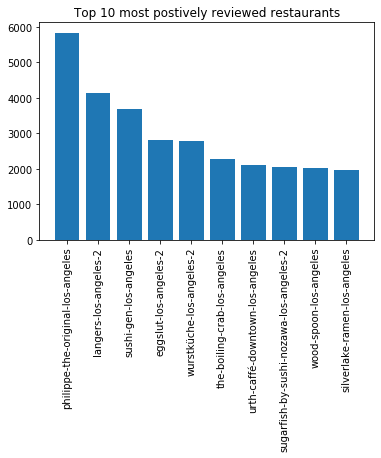

In [0]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 


plt.bar(range(len(res_score)), list(res_score.values()), align='center')
plt.title('Top 10 most postively reviewed restaurants', fontdict=None, loc='center', pad=None)
plt.xticks(range(len(res_score)), list(res_score.keys()), rotation='vertical')

plt.show()

In [0]:
business_mapping = {}
business_df = pd.read_json('businesses.json')
business_mapping = pd.Series(business_df.name.values,index=business_df.id).to_dict()
restaurant_name = []
for i in restaurants:
  if i in business_mapping:
    restaurant_name.append(business_mapping[i])

Word cloud for top 50 most positively reviewed restaurants

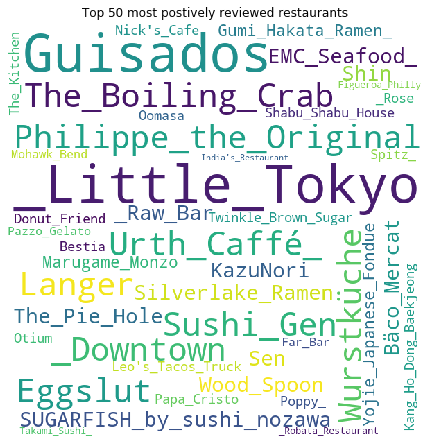

In [0]:
# importing all necessery modules 
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
text = ' '
for i in restaurant_name[:50]:
  name = i.replace(' ','_')
  text = text + name + ' '

wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='white',                
                min_font_size = 10).generate(text) 
  
# plot the WordCloud image                        
plt.figure(figsize = (6, 6), facecolor = None)
plt.title('Top 50 most postively reviewed restaurants', fontdict=None, loc='center', pad=None)
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

Some sample plots to show top recommended dishes from the most favoured restaurant

In [0]:
#recommendation.csv : name of file with top 5 recommended dishes per restaurant
top_restaurants = {}

for restaurant in scores:
  rscores = [(menu_item, score) for menu_item, score in scores[restaurant].items()]
  rscores.sort(key=lambda tup: tup[1], reverse=True)
  total_recommendations = 0
  for i in rscores:
    total_recommendations += i[1]
  top_restaurants[restaurant] = total_recommendations
  rscores = rscores[:5]
  recommendations = list(map(lambda x: x[0], rscores))

sorted_dic = [(k, top_restaurants[k]) for k in sorted(top_restaurants, key=top_restaurants.get, reverse=True)]
res_score = {}

restaurants = []
for i in range(10):
  res_score[sorted_dic[i][0]] = sorted_dic[i][1]

for i in sorted_dic:
  restaurants.append(i[0])

print('the most favoured restaurant is:',restaurants[0])

the most favoured restaurant is: philippe-the-original-los-angeles


Top 10 recommended dishes for the most favoured restaurant plot

In [0]:
for restaurant in scores:
  rscores = [(menu_item, score) for menu_item, score in scores[restaurant].items()]
  rscores.sort(key=lambda tup: tup[1], reverse=True)
  total_recommendations = 0
  for i in rscores:
    total_recommendations += i[1]
  top_restaurants[restaurant] = total_recommendations
  rscores = rscores[:10]
  plot_1 = {}
  if restaurant == 'philippe-the-original-los-angeles':
    for i in rscores:
      plot_1[i[0]] = i[1]
    break;

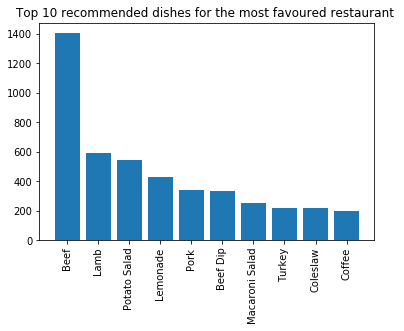

In [0]:
plt.bar(range(len(plot_1)), list(plot_1.values()), align='center')
plt.title('Top 10 recommended dishes for the most favoured restaurant', fontdict=None, loc='center', pad=None)
plt.xticks(range(len(plot_1)), list(plot_1.keys()), rotation='vertical')
plt.show()

Top 50 recommended dishes for the most favoured restaurant word cloud

In [0]:
for restaurant in scores:
  rscores = [(menu_item, score) for menu_item, score in scores[restaurant].items()]
  rscores.sort(key=lambda tup: tup[1], reverse=True)
  total_recommendations = 0
  for i in rscores:
    total_recommendations += i[1]
  top_restaurants[restaurant] = total_recommendations
  rscores = rscores[:50]
  plot_1 = []
  if restaurant == 'philippe-the-original-los-angeles':
    for i in rscores:
      plot_1.append(i[0])
    break;

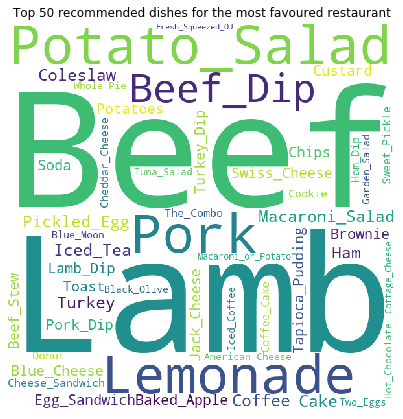

In [0]:
text = ' '
for i in plot_1:
  name = i.replace(' ','_')
  text = text + name + ' '

wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='white',                
                min_font_size = 10).generate(text) 
  
# plot the WordCloud image                        
plt.figure(figsize = (6, 6), facecolor = None)
plt.title('Top 50 recommended dishes for the most favoured restaurant', fontdict=None, loc='center', pad=None)
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()